# MLPRegressor

In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import stde

import kerastuner as kt
import tensorflow as tf


In [18]:
from tensorflow.python.client import device_lib

print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2022-11-20 12:43:21.689178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 12:43:21.689395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 12:43:21.689545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 12:43:21.689904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 12:43:21.690059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

## Read the etl info results

In [19]:
df_info = pd.read_csv('../dataset_clean/options_csv_v1_etl.csv')
df_info

,remove_time_features,generic_features,remove_atypical_values,feature_combination,remove_feature_selection,remove_invalid_correlated_features
0,False,False,False,False,False,False


## Read the dataset

In [20]:
df = pd.read_csv('../dataset/V2_PlatteRiverWeir_features_merged_all.csv')
df

,Unnamed: 0.1,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,...,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma,RiverArea
0,0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,...,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,47072.0
1,1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,...,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,47545.0
2,2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,...,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,48159.0
3,3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,...,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,48141.0
4,4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,...,-1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,48743.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42054,42054,42054,2019-10-11 09:00:00,2019-10-11T08:59:53,StateLineWeir_20191011_Farrell_409.jpg,USGS,6674500,MDT,2.54,434.0,...,1900,9284.0,77521.0,38385.370066,15952.029728,0.0,70085.0,37550.894823,16444.401209,38366.0
42055,42055,42055,2019-10-11 10:00:00,2019-10-11T09:59:52,StateLineWeir_20191011_Farrell_410.jpg,USGS,6674500,MDT,2.54,434.0,...,1900,10092.0,74614.0,40162.989292,15467.708856,0.0,70061.0,39397.339095,16009.008049,38641.0
42056,42056,42056,2019-10-11 11:00:00,2019-10-11T10:59:52,StateLineWeir_20191011_Farrell_411.jpg,USGS,6674500,MDT,2.54,434.0,...,1900,7067.0,83260.0,42095.946590,16770.357949,0.0,76335.0,41350.006568,17489.374617,39500.0
42057,42057,42057,2019-10-11 12:00:00,2019-10-11T11:59:53,StateLineWeir_20191011_Farrell_412.jpg,USGS,6674500,MDT,2.54,434.0,...,1900,6283.0,83045.0,45345.490954,17498.432849,0.0,78882.0,44553.920296,18268.294896,39716.0


In [21]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year
df['Month'] = df['SensorTime'].dt.month

In [22]:
df.dtypes

Unnamed: 0.1                 int64
Unnamed: 0                   int64
SensorTime          datetime64[ns]
CaptureTime                 object
Filename                    object
                         ...      
WwCurveLineMean            float64
WwCurveLineSigma           float64
RiverArea                  float64
Year                         int64
Month                        int64
Length: 64, dtype: object

In [23]:
df = df[df.Stage > 0]
df = df[df.Discharge > 0]

In [24]:

df.isna().sum()

Unnamed: 0.1        0
Unnamed: 0          0
SensorTime          0
CaptureTime         0
Filename            0
                   ..
WwCurveLineMean     0
WwCurveLineSigma    0
RiverArea           0
Year                0
Month               0
Length: 64, dtype: int64

## Divide dataset to X and Y

In [25]:
df_train = df[(df.Year >= 2012) & (df.Year <= 2016)]
df_test = df[(df.Year >= 2017) & (df.Year <= 2019)]

In [26]:
df_train = df_train.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_test = df_test.drop(columns=["Year", "SensorTime", "CaptureTime"])

In [27]:
np.random.seed(0)

y_train = df_train[["Stage"]]
X_train = df_train[["RiverArea", "Month"]]

temp = list(zip(X_train.values, y_train.values))
np.random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train, y_train = np.array(X_train), np.array(y_train)

y_test = df_test[["Stage"]]
X_test = df_test[["RiverArea", "Month"]]

temp = list(zip(X_test.values, y_test.values))
np.random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test, y_test = np.array(X_test), np.array(y_test)

In [28]:
print(X_train.shape)
print(y_train.shape)

(20304, 2)
(20304, 1)


In [29]:
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]

print(input_shape, output_shape)

2 1


## Train model

In [30]:
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=input_shape))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 16, max_value = 128, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units, activation = 'relu'))
  hp_units_2 = hp.Int('units_2', min_value = 32, max_value = 256, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_2, activation = 'relu'))
  hp_units_3 = hp.Int('units_3', min_value = 32, max_value = 256, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_3, activation = 'relu'))
  hp_units_4 = hp.Int('units_4', min_value = 16, max_value = 128, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_4, activation = 'relu'))
  """
  hp_units_5 = hp.Int('units_5', min_value = 128, max_value = 512, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_5, activation = 'relu'))
  hp_units_6 = hp.Int('units_6', min_value = 64, max_value = 512, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_6, activation = 'relu'))
  hp_units_7 = hp.Int('units_7', min_value = 64, max_value = 512, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_7, activation = 'relu'))
  hp_units_8 = hp.Int('units_8', min_value = 32, max_value = 512, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units_8, activation = 'relu'))"""

  model.add(tf.keras.layers.Dense(output_shape, activation = 'linear'))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate), loss = 'mse', metrics = ['mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])
  
  return model

In [31]:
tuner = kt.RandomSearch(model_builder,
                        objective = 'val_loss', 
                        max_trials = 10,
                        #directory = 'random_search_starter',
                        project_name = 'MLPtf') 

In [32]:
tuner.search(X_train, y_train, epochs = 40, validation_data = (X_test, y_test))

Trial 10 Complete [00h 01m 25s]
val_loss: 0.3306446969509125

Best val_loss So Far: 0.3228565752506256
Total elapsed time: 00h 13m 59s
INFO:tensorflow:Oracle triggered exit


In [33]:
best_model = tuner.get_best_models(1)[0]

In [34]:

best_hyperparameters = tuner.get_best_hyperparameters(1)[0] 

## Test model

In [35]:
best_model.evaluate(X_test, y_test)


621/621 [==============================] - 1s 2ms/step - loss: 0.3229 - mse: 0.3229 - rmse: 0.5682 - mae: 0.4693 - mape: 16.7099


[0.3228565752506256,
 0.3228565752506256,
 0.5682047009468079,
 0.46927815675735474,
 16.709903717041016]

In [36]:
y_pred = best_model.predict(X_test)

621/621 [==============================] - 1s 679us/step


In [37]:
print("R^2: ", r2_score(y_test, y_pred))
print("mse: ", mean_squared_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("mape: ", mean_absolute_percentage_error(y_test, y_pred))
print("Error estandar: ", stde(y_test.squeeze(),
      y_pred.squeeze(), ddof=2))


R^2:  0.28924435501921086
mse:  0.322856712952174
rmse:  0.5682048160233896
mae:  0.4692783540673817
mape:  0.1670989773745085
Error estandar:  0.5681103905779521


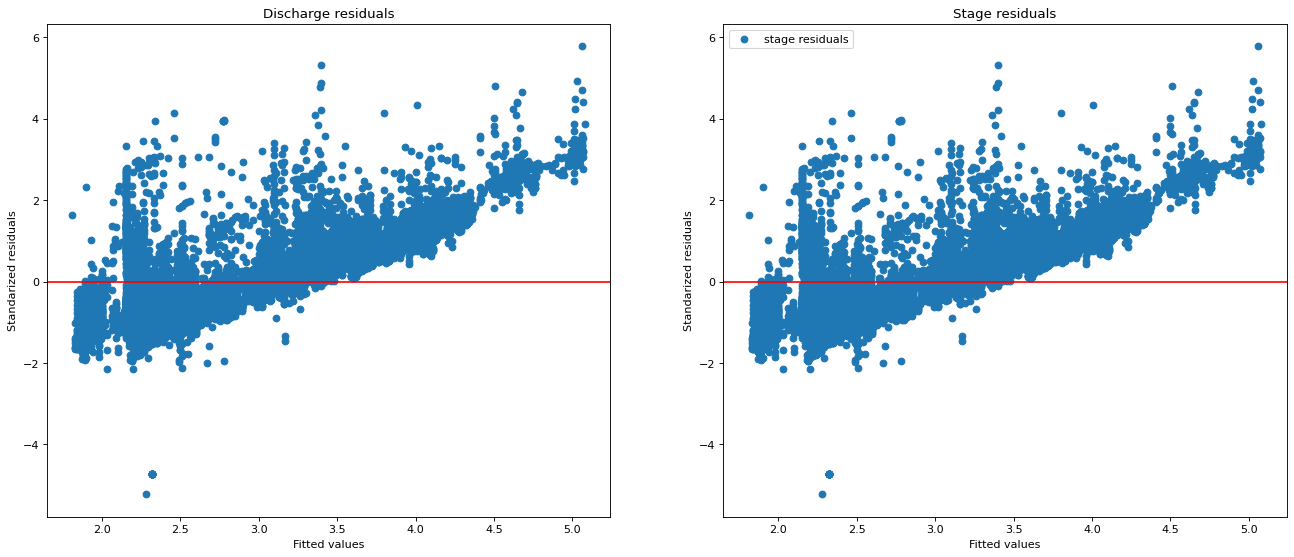

In [38]:
residuals = y_test - y_pred
residuals_std = residuals/residuals.std()

y_real_stage = np.array([i[0] for i in y_test])
residual_stage = np.array([i[0] for i in residuals])

y_real_discharge = np.array([i[-1] for i in y_test])
residual_discharge = np.array([i[-1] for i in residuals])


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[1].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
ax[0].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[1].axhline(y=0.0, color='r', linestyle='-')
ax[0].axhline(y=0.0, color='r', linestyle='-')

ax[1].set_title("Stage residuals")
ax[0].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

In [44]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

#figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

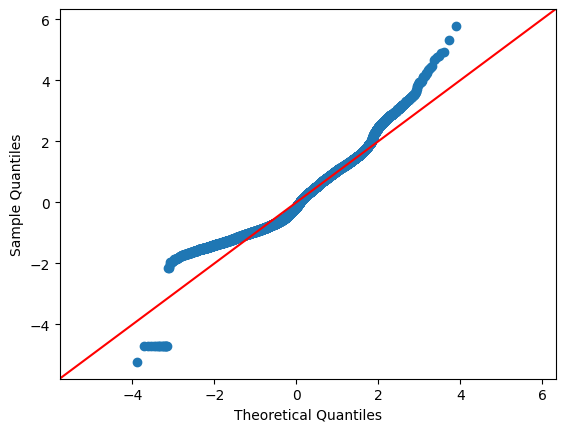

In [45]:
figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')
plt.show()

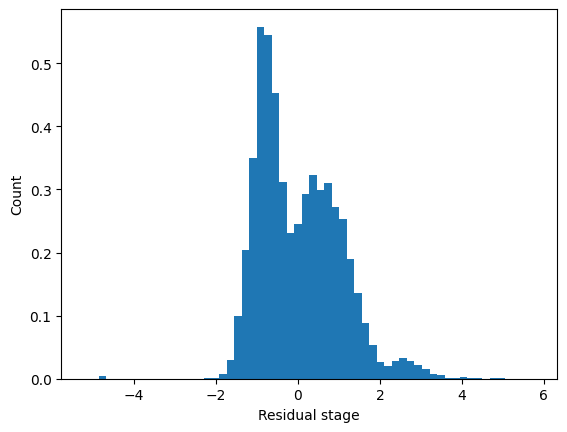

In [42]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()

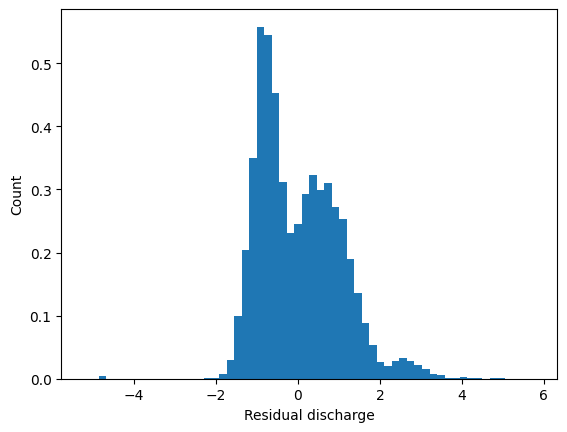

In [43]:
plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()

In [46]:
stat, pval = normal_ad(residual_discharge / residual_discharge.std())
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.
